<a href="https://colab.research.google.com/github/harnettd/learn-PyTorch/blob/main/02-Neural-Network-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Neural Network Classification

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Generate Data

In [5]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)
df = pd.DataFrame(
    np.hstack((X, y.reshape(-1, 1))),
    columns=['X1', 'X2', 'y']
)
df.head()

,X1,X2,y
0,0.754246,0.231481,1.0
1,-0.756159,0.153259,1.0
2,-0.815392,0.173282,1.0
3,-0.393731,0.692883,1.0
4,0.442208,-0.896723,0.0


### EDA

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      1000 non-null   float64
 1   X2      1000 non-null   float64
 2   y       1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


In [8]:
df.describe()

,X1,X2,y
count,1000.000000,1000.000000,1000.00000
mean,-0.000448,-0.000804,0.50000
std,0.639837,0.641156,0.50025
min,-1.059502,-1.067768,0.00000
25%,-0.619251,-0.612176,0.00000
50%,0.008762,-0.003949,0.50000
75%,0.621933,0.624822,1.00000
max,1.033712,1.036004,1.00000


In [6]:
df['y'].value_counts()

,count
y,
1.0,500
0.0,500


<Axes: xlabel='X1', ylabel='X2'>

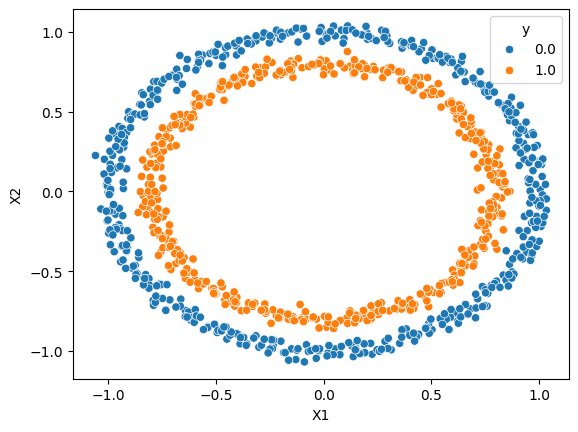

In [10]:
sns.scatterplot(data=df, x='X1', y='X2', hue='y')

## Train-Test Split

In [14]:
X.shape, y.shape

((1000, 2), (1000,))

In [26]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [34]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([800]),
 torch.Size([200, 2]),
 torch.Size([200]))

# Build Model

In [23]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, X):
        return self.layer_2(self.layer_1(X))

In [24]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [56]:
y_logits = model_0(X_test.to(device))
print(f'Model output shape: {y_logits.shape}')
print(f'y_test shape: {y_test.shape}')
y_preds_probs = torch.sigmoid(y_logits)
y_preds_labels = torch.round(y_preds_probs)
y_preds = y_preds_labels.squeeze()
y_preds[:10]

Model output shape: torch.Size([200, 1])
y_test shape: torch.Size([200])


tensor([1., 1., 0., 1., 0., 0., 0., 0., 0., 1.], grad_fn=<SliceBackward0>)

## Train Model

In [63]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [46]:
def accuracy_fn(y_true, y_pred):
    n_preds = len(y_true)
    n_correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = n_correct / n_preds
    return accuracy

In [64]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    y_train_logits = model_0(X_train).squeeze()
    y_train_labels = torch.round(torch.sigmoid(y_train_logits))

    loss = loss_fn(y_train_logits, y_train)
    accuracy = accuracy_fn(y_train, y_train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
        y_test_labels = torch.round(torch.sigmoid(y_test_logits))
        test_loss = loss_fn(y_test_logits, y_test)
        test_accuracy = accuracy_fn(y_test, y_test_labels)

    ### Printouts
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {accuracy:.3f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_accuracy:.3f}')


Epoch: 0 | Loss: 0.71428 | Accuracy: 0.489 | Test Loss: 0.71727 | Test Accuracy: 0.480
Epoch: 10 | Loss: 0.70601 | Accuracy: 0.489 | Test Loss: 0.70955 | Test Accuracy: 0.485
Epoch: 20 | Loss: 0.70125 | Accuracy: 0.487 | Test Loss: 0.70488 | Test Accuracy: 0.500
Epoch: 30 | Loss: 0.69835 | Accuracy: 0.490 | Test Loss: 0.70187 | Test Accuracy: 0.500
Epoch: 40 | Loss: 0.69652 | Accuracy: 0.487 | Test Loss: 0.69986 | Test Accuracy: 0.505
Epoch: 50 | Loss: 0.69533 | Accuracy: 0.486 | Test Loss: 0.69846 | Test Accuracy: 0.495
Epoch: 60 | Loss: 0.69455 | Accuracy: 0.492 | Test Loss: 0.69748 | Test Accuracy: 0.485
Epoch: 70 | Loss: 0.69403 | Accuracy: 0.495 | Test Loss: 0.69678 | Test Accuracy: 0.495
Epoch: 80 | Loss: 0.69368 | Accuracy: 0.497 | Test Loss: 0.69627 | Test Accuracy: 0.485
Epoch: 90 | Loss: 0.69345 | Accuracy: 0.500 | Test Loss: 0.69590 | Test Accuracy: 0.495
